In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from os import listdir, makedirs
import ast
import pickle

In [2]:
# Data location
PROJECT_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp-2'
DATA_PATH = f'{PROJECT_PATH}/data'
RESULTS_PATH = f'{PROJECT_PATH}/results'
TRANSITION_RESULTS_DIR = 'transition-influence/training'
FIG_PATH = f'{PROJECT_PATH}/figs'

# Model info
MODELS = [d for d in listdir(DATA_PATH) if d[0] != '.']

TRANSITION_INFLUENCE_COLORS = {
    'incidental': '#F52342',
    'true': '#FFBC42'
}

In [3]:
# Mkae figure path if it does not exist
makedirs(FIG_PATH, exist_ok=True)

# Functions

## Helper Functions

In [4]:
def load_data_from_dir(dpath):
    """
    Load data from a directory into a single pandas DataFrame
    
    Arguments
    ---------
    dpath : str
        path to data directory
        
    Returns
    -------
    data : pd.DataFrame
        phase data
    """
    data = []
    for f in listdir(dpath):
        if f.startswith('.'):
            continue
        data.append(pd.read_csv(f'{dpath}/{f}'))
    data = pd.concat(data)
    return data

def information_from_label(model_label):
    """
    Get field information from model label

    Arguments
    ---------
    model_label : str
        model label
    
    Returns
    -------
    fields
    """
    fields = {}
    for field in model_label.split('_'):
        if not '-' in field:
            continue
        key, value = field.split('-')
        fields[key] = value
    return fields

def convert_states_to_labels(states):
    """
    Convert array of states to string labels

    Arguments
    ---------
    states : np.ndarray
        Array represent states by their features

    Returns
    -------
    labels : list
        state labels
    """
    labels = [''.join(label) for label in states.astype(str)]
    return labels

def standardize_reps_order(reps):
    """
    Standardize the order of representations

    Arguments
    ---------
    reps : dict
        representation dictionary

    Returns
    -------
    reps : dict
        standardized representation dictionary
    """
    
    # Get indices for standardized ordering
    idx_sorted_S = np.lexsort(reps['S'].T[::-1])
    idx_sorted_F = np.lexsort(reps['F_raw'].T[::-1])
    S = reps['S'][idx_sorted_S]
    F_raw = reps['F_raw'][idx_sorted_F]

    # Re-order rows by whether starts are conjunctive or not
    if reps['agent_info']['conjunctive_starts']:
        M = reps['M'][idx_sorted_S]
        bias = reps['bias'][idx_sorted_S]
        row_labels = convert_states_to_labels(S)
    else:
        M = reps['M'][idx_sorted_F]
        bias = reps['bias'][idx_sorted_F]
        row_labels = convert_states_to_labels(F_raw)

    # Re-order columns by whether successors are conjunctive or not
    if reps['agent_info']['conjunctive_successors']:
        M = M.T[idx_sorted_S].T
        bias = bias.T[idx_sorted_S].T
        col_labels = convert_states_to_labels(S)
    else:
        M = M.T[idx_sorted_F].T
        bias = bias.T[idx_sorted_F].T
        col_labels = convert_states_to_labels(F_raw)

    # Assign re-ordered representations
    reps['S'] = S
    reps['F_raw'] = F_raw
    reps['M'] = M
    reps['bias'] = bias
    reps['row_labels'] = row_labels
    reps['col_labels'] = col_labels

    return reps

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def round_interval_labels(interval_series, n):
    """
    Round interval labels to n decimal places

    Arguments
    ---------
    interval_series : pd.Series
        series of pandas Interval objects
    
    Returns
    -------
    interval_series : pd.Series
        series of pandas Interval objects with rounded labels
    """
    return interval_series.apply(
        lambda x: pd.Interval(
            np.abs(round(x.left, n)),
            np.abs(round(x.right, n))
        )
    )

def bin_params(params, n_bins, method=pd.cut):
    """
    Bin parameters into n_bins

    Arguments
    ---------
    params : np.ndarray
        parameter values
    n_bins : int
        number of bins
    
    Returns
    -------
    params_binned : np.ndarray
        binned parameter values
    """
    params_binned = method(params, n_bins)
    params_binned = round_interval_labels(params_binned, 2)
    return params_binned



def convert_str_to_array(array_string):
    """
    Convert a string representation of an array to a numpy array

    Arguments
    ---------
    array_string : str
        String representation of an array
    
    Returns
    -------
    arr : numpy.Array
        Numpy array of string
    """
    array_string = array_string.replace('\n', '')
    array_string = array_string.replace('[ ', '[')
    array_string = array_string.replace('  ', ',')
    array_string = array_string.replace(' ', ',')
    arr = ast.literal_eval(array_string)
    arr = np.array(arr)
    return arr

def get_target_frequency(df):

    # Get rates of each target per model and id
    target_counts = df.groupby(
        ['id', 'model_label', 'target']
        ).size().reset_index(name='count')
    total_counts = target_counts.groupby(
        ['id', 'model_label']
        )['count'].transform('sum')
    target_counts['rate'] = target_counts['count']/total_counts

    # Find the highest and lowest rates per id and model
    highest_rate = target_counts.groupby(
        ['id', 'model_label']
        )['rate'].transform('max')

    # Categorize each item
    target_counts['freq_target'] = target_counts['rate'] == highest_rate
    target_counts['freq_target'] = target_counts['freq_target'].astype(int)
    df = pd.merge(
        df,
        target_counts,
    )

    return df

## Plot Functions

In [5]:
def plot_training_curve(
        df,
        y,
        grouping_var,
        palette = 'rocket',
        hue_order = None,
        title = None,
        legend_title = None):
    """
    Plot training curve

    Arguments
    ---------
    df : pd.DataFrame
        training data
    y : str
        variable to plot on y-axis ('reward' or 'p')
    grouping_var : str
        variable to group by
    
    palette : list
        color palette
    title : str
        title for plot
    legend_title : str
        title for legend
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(6, 3))
    blocks = df['block'].unique()
    if len(blocks) > 1:
        ax.axvline(np.max(df['trial'])/len(blocks), color='black')
    for block in blocks:
        idx = df['block'] == block
        sns.lineplot(
            data = df.loc[idx],
            x = 'trial',
            y = y,
            hue = grouping_var,
            palette = palette,
            hue_order = hue_order,
            ci = None
        )
    n_labels = len(df[grouping_var].unique())
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        handles[-n_labels:],
        labels[-n_labels:],
        title = legend_title,
        loc = (1.05, .45)
    )
    ax.set_xlabel('Trial')
    if y == 'reward':
        max_reward = np.max(df['reward'])
        ax.axhline(max_reward/2, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Reward')
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.axhline(.25, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('P(Choice)')
        ax.set_ylim(0, 1)
    elif y == 'resid':
        ax.axhline(.72, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Residual')
        ax.set_ylim(0, 1)
    ax.set_title(title, loc='left')

def plot_param_interaction(
        df,
        continous_param,
        binned_param,
        y,
        title = None,
        legend_title = None,
        xlabel = None,
        ylabel = None,
        palette = 'rocket'
):
    
    # Get average reward by alpha and segmentation bin
    plot_df = df[['id', continous_param, binned_param, y]]
    plot_df = plot_df.groupby(['id', continous_param, binned_param])
    plot_df = plot_df.mean().reset_index()

    # Y-intercept of chance line
    if y == 'reward':
        max_reward = np.max(df['reward'])
        chance = max_reward/2
    elif y == 'p':
        chance = .25
    elif y == 'coef':
        chance = 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(chance, color='black', linestyle='--', zorder=0)
    n_bins = len(plot_df[binned_param].unique())
    for i, param_bin in enumerate(plot_df[binned_param].unique()):
        idx = plot_df[binned_param] == param_bin
        sns.regplot(
            data = plot_df.loc[idx],
            x = continous_param,
            y = y,
            scatter = False,
            color = sns.color_palette(palette, n_bins)[i],
            label = param_bin
        )
    ax.legend(title=legend_title, loc=(1.05, .45))
    if y == 'reward':
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.set_ylim(0, 1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, loc='left')
    set_axis_ratio(ax)

# Load Data

## Training

In [6]:
# Load training data
training_df = []
for model in MODELS:
    model_df = load_data_from_dir(f'{DATA_PATH}/{model}/training')
    model_info = information_from_label(model)
    for key, value in model_info.items():
        model_df[key] = value
    training_df.append(model_df)
training_df = pd.concat(training_df)
training_df = training_df.reset_index(drop=True)
training_df['block'] = 1
training_df = get_target_frequency(training_df)
training_df['depth'] = training_df['depth'].astype(int)
training_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,model,bias,sdim,depth,freq,pairs,block,count,rate,freq_target
0,388,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.374362,0,3.440377,3.440377,1,0.937979,1.413159,False,...,ff,none,2,1,nonuniform,fact,1,180,0.166667,1
1,388,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.374362,0,3.440377,3.440377,1,0.937979,1.413159,False,...,ff,none,2,1,nonuniform,fact,1,180,0.166667,1
2,388,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.374362,0,3.440377,3.440377,1,0.937979,1.413159,False,...,ff,none,2,1,nonuniform,fact,1,180,0.166667,1
3,388,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.374362,0,3.440377,3.440377,1,0.937979,1.413159,False,...,ff,none,2,1,nonuniform,fact,1,90,0.083333,0
4,388,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.374362,0,3.440377,3.440377,1,0.937979,1.413159,False,...,ff,none,2,1,nonuniform,fact,1,180,0.166667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079995,385,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.305551,0,5.990132,5.990132,1,0.228435,3.664174,False,...,ff,none,2,1,nonuniform,fact,1,180,0.166667,1
1079996,385,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.305551,0,5.990132,5.990132,1,0.228435,3.664174,False,...,ff,none,2,1,nonuniform,fact,1,180,0.166667,1
1079997,385,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.305551,0,5.990132,5.990132,1,0.228435,3.664174,False,...,ff,none,2,1,nonuniform,fact,1,90,0.083333,0
1079998,385,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.305551,0,5.990132,5.990132,1,0.228435,3.664174,False,...,ff,none,2,1,nonuniform,fact,1,180,0.166667,1


## Test

In [7]:
test_df = []
for model in MODELS:
    model_df = load_data_from_dir(f'{DATA_PATH}/{model}/test')
    model_info = information_from_label(model)
    for key, value in model_info.items():
        model_df[key] = value
    test_df.append(model_df)
test_df = pd.concat(test_df)
test_df = test_df.reset_index(drop=True)
test_df['depth'] = test_df['depth'].astype(int)
test_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,ev,p,reward,correct,model,bias,sdim,depth,freq,pairs
0,150,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.398224,0,0.912255,0.912255,1,0.046343,1.778884,False,...,0.000000,0.25000,0,0,ff,none,2,1,nonuniform,fact
1,150,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.398224,0,0.912255,0.912255,1,0.046343,1.778884,False,...,0.000000,0.25000,0,0,ff,none,2,1,nonuniform,fact
2,150,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.398224,0,0.912255,0.912255,1,0.046343,1.778884,False,...,0.000000,0.25000,0,0,ff,none,2,1,nonuniform,fact
3,150,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.398224,0,0.912255,0.912255,1,0.046343,1.778884,False,...,0.000000,0.25000,0,0,ff,none,2,1,nonuniform,fact
4,150,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.398224,0,0.912255,0.912255,1,0.046343,1.778884,False,...,117.507963,1.00000,1,0,ff,none,2,1,nonuniform,fact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143995,149,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.899879,0,0.033969,0.033969,1,0.465341,24.648536,False,...,257.146196,0.49992,1,0,ff,none,2,1,nonuniform,fact
143996,149,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.899879,0,0.033969,0.033969,1,0.465341,24.648536,False,...,0.000000,0.25000,0,0,ff,none,2,1,nonuniform,fact
143997,149,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.899879,0,0.033969,0.033969,1,0.465341,24.648536,False,...,0.000000,0.25000,0,0,ff,none,2,1,nonuniform,fact
143998,149,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.899879,0,0.033969,0.033969,1,0.465341,24.648536,False,...,0.000000,0.25000,0,0,ff,none,2,1,nonuniform,fact


## Representations

In [8]:
representations = {}
for model in MODELS:
    model_info = information_from_label(model)
    for fname in listdir(f'{DATA_PATH}/{model}/representations'):
        if fname.startswith('.'):
            continue
        agent_id = int(fname.split('_')[1].replace('.pkl', ''))
        with open(f'{DATA_PATH}/{model}/representations/{fname}', 'rb') as f:
            representations[model, agent_id] = standardize_reps_order(
                pickle.load(f)
            )
            for key, value in model_info.items():
                representations[model, agent_id][key] = value
            representations[model, agent_id]['edim'] =  4

## Subject Information 

In [9]:
subj_df = test_df[[
    'id',
    'model_label',
    'sdim',
    'depth',
    'freq',
    'pairs',
    'bias',
    'alpha',
    'beta',
    'gamma',
    'segmentation'
]]
subj_df = subj_df.drop_duplicates()
subj_df = subj_df.reset_index(drop=True)
subj_df['segmentation_binned'] = bin_params(subj_df['segmentation'], 10)

# Merge subject data with choice data
training_df = pd.merge(training_df, subj_df)
test_df = pd.merge(test_df, subj_df)

subj_df

,id,model_label,sdim,depth,freq,pairs,bias,alpha,beta,gamma,segmentation,segmentation_binned
0,150,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.398224,0.912255,1,0.046343,"(0.0, 0.1]"
1,636,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.312583,0.430138,1,0.268855,"(0.2, 0.3]"
2,622,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.453105,2.533035,1,0.777226,"(0.7, 0.8]"
3,144,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.838140,0.418640,1,0.664097,"(0.6, 0.7]"
4,178,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.499616,0.604428,1,0.624757,"(0.6, 0.7]"
...,...,...,...,...,...,...,...,...,...,...,...,...
995,161,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.718150,0.119758,1,0.071748,"(0.0, 0.1]"
996,607,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.241079,0.886207,1,0.770314,"(0.7, 0.8]"
997,613,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.939557,0.356030,1,0.123306,"(0.1, 0.2]"
998,175,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.762173,5.556745,1,0.245636,"(0.2, 0.3]"


## Transition Influence

### Results

In [11]:
trans_influence_df = []
for group_label in listdir(RESULTS_PATH):
    if group_label.startswith('.'):
        continue
    this_path = f'{RESULTS_PATH}/{group_label}/transition-influence/training/agent'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        
        # Get agent ID from file name
        agent_id = int(fname.replace('.pkl', '').split('_')[1])

        # Load trace
        with open(f'{this_path}/{fname}', 'rb') as f:
            trace = pickle.load(f)

        # Extract coefficients
        coefs = az.summary(trace)['mean'].values
        n_actions = int(len(coefs)/2)
        coefs = coefs.reshape(-1, 2)
        
        # Add to full results set
        try:
            coefs_df = pd.DataFrame({
                'model_label': group_label,
                'id': agent_id,
                'action': np.arange(1, n_actions + 1),
                'incidental': coefs[:, 0],
                'true': coefs[:, 1]
            })

        except:
            print('Error with agent:', agent_id)
            continue


        trans_influence_df.append(coefs_df)

trans_influence_df = pd.concat(trans_influence_df)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Convert to long
trans_influence_df = pd.melt(
    trans_influence_df,
    id_vars = ['model_label', 'id', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Add parameter information

trans_influence_df = pd.merge(
    trans_influence_df,
    subj_df,
    on = ['model_label', 'id']
)

trans_influence_df

,model_label,id,action,transition,coef,sdim,depth,freq,pairs,bias,alpha,beta,gamma
0,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,228,1,incidental,1.159,2,3,uniform,fact,none,0.505428,0.081583,1
1,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,228,2,incidental,0.710,2,3,uniform,fact,none,0.505428,0.081583,1
2,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,228,3,incidental,1.294,2,3,uniform,fact,none,0.505428,0.081583,1
3,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,200,1,incidental,3.130,2,3,uniform,fact,none,0.522943,20.578293,1
4,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,200,2,incidental,3.154,2,3,uniform,fact,none,0.522943,20.578293,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11119,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,225,2,true,2.983,2,4,nonuniform,nonfact,none,0.765853,0.710036,1
11120,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,225,3,true,2.714,2,4,nonuniform,nonfact,none,0.765853,0.710036,1
11121,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,231,1,true,2.110,2,4,nonuniform,nonfact,none,0.379396,0.181598,1
11122,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,231,2,true,1.893,2,4,nonuniform,nonfact,none,0.379396,0.181598,1


In [13]:
trans_influence_trial_df = []
for group_label in listdir(RESULTS_PATH):
    if group_label.startswith('.'):
        continue
    this_path = f'{RESULTS_PATH}/{group_label}/transition-influence/training/trial'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        
        # Get agent ID from file name
        trial = int(fname.replace('.pkl', '').split('_')[1])

        # Load trace
        with open(f'{this_path}/{fname}', 'rb') as f:
            trace = pickle.load(f)

        # Extract coefficients
        coefs = az.summary(trace)['mean'].values
        n_actions = int(len(coefs)/2)
        coefs = coefs.reshape(-1, 2)
        
        # Add to full results set
        try:
            coefs_df = pd.DataFrame({
                'model_label': group_label,
                'trial': trial,
                'action': np.arange(1, n_actions + 1),
                'incidental': coefs[:, 0],
                'true': coefs[:, 1]
            })

        except:
            print('Error with agent:', agent_id)
            continue


        trans_influence_trial_df.append(coefs_df)

trans_influence_trial_df = pd.concat(trans_influence_trial_df)
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)

# Convert to long
trans_influence_trial_df = pd.melt(
    trans_influence_trial_df,
    id_vars = ['model_label', 'trial', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)

# Add parameter information
trans_influence_trial_df = pd.merge(
    trans_influence_trial_df,
    subj_df[['model_label', 'depth', 'freq', 'pairs']].drop_duplicates(),
    on = ['model_label']
)

trans_influence_trial_df

,model_label,trial,action,transition,coef,depth,freq,pairs
0,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,980,1,incidental,3.211,3,uniform,fact
1,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,980,2,incidental,2.450,3,uniform,fact
2,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,980,3,incidental,3.691,3,uniform,fact
3,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,770,1,incidental,3.055,3,uniform,fact
4,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,770,2,incidental,2.737,3,uniform,fact
...,...,...,...,...,...,...,...,...
82753,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,741,2,true,1.965,4,nonuniform,nonfact
82754,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,741,3,true,1.894,4,nonuniform,nonfact
82755,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,755,1,true,2.439,4,nonuniform,nonfact
82756,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,755,2,true,2.684,4,nonuniform,nonfact


### Plot average successor representation per segmentation bin

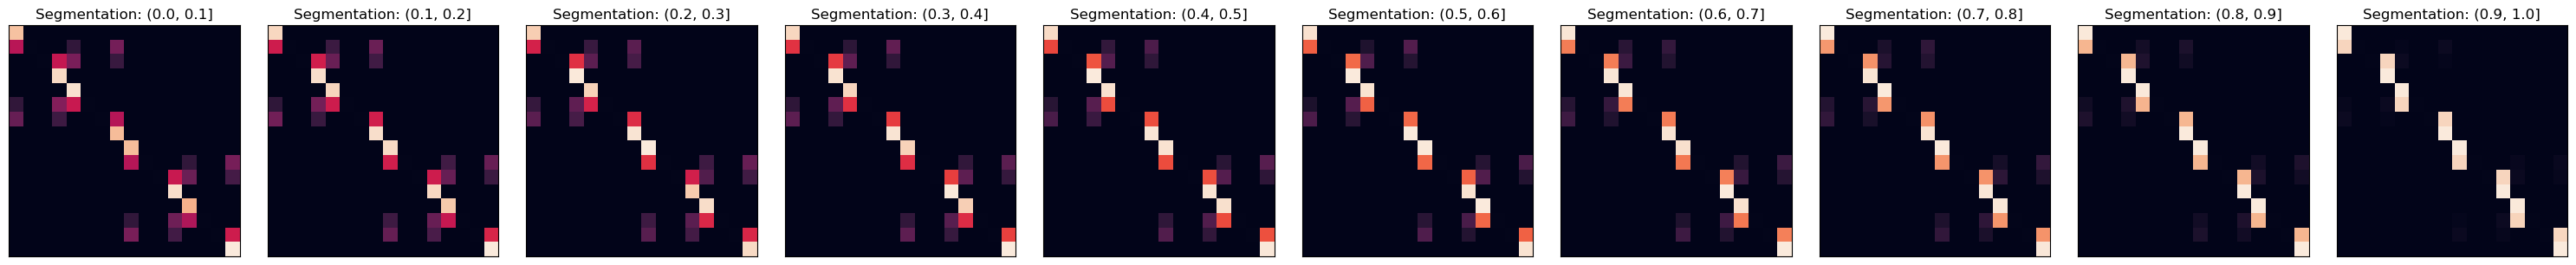

In [80]:
# Init dict to store all M matrices
seg_labels = np.unique(subj_df['segmentation_binned'])
all_M = {
    seg_label: []
    for seg_label in seg_labels
}
for key in representations.keys():
    agent_id = key[1]
    
    # Get segmentation bin label
    idx = subj_df['id'] == agent_id
    seg_label = subj_df.loc[idx, 'segmentation_binned'].values[0]

    # Add to all_M
    all_M[seg_label].append(representations[key]['M'])

# Average across M matrices for each segmentation bin
all_M = {
    seg_label: np.mean(all_M[seg_label], axis=0)
    for seg_label in all_M.keys()
}

# Plot average M matrices
n_subplots = len(seg_labels)
fig, axs = plt.subplots(1, n_subplots, figsize=(3*n_subplots, 3))
for i, seg_label in enumerate(seg_labels):
    ax = axs[i]
    ax.imshow(all_M[seg_label], cmap='rocket')
    ax.set_title(f'Segmentation: {seg_label}')
    ax.set_xticks([])
    ax.set_yticks([])
    set_axis_ratio(ax)
fig.tight_layout()


### Get incidental vs true information weight

In [33]:
def get_M_masks(key, representations):
     feats = []
     for lab in representations[key]['row_labels']:
          if len(lab) == (int(representations[key]['edim']) + 1):
              lab = lab.replace('10', 'a')
          feats.append([i != '0' for i in lab])
     feats = np.array(feats)
     true_mask = feats@feats.T
     incidental_mask = np.logical_not(true_mask)
     np.fill_diagonal(true_mask, False)
     return true_mask, incidental_mask

In [34]:
# Get incidental weights for each model and agent
incidental_weights = []
n_agents = int(len(representations)/len(MODELS))
for model in MODELS:
    for i in range(1, n_agents + 1):

        # Get within- (true) and between-feature (incidental) masks
        true_mask, incidental_mask = get_M_masks((model, i), representations)

        # Sum information in true vs incidental regions of M
        M = representations[model, i]['M']
        true_sum = np.sum(M[true_mask])
        incidental_sum = np.sum(M[incidental_mask])
        true_max = np.max(M[true_mask])
        incidental_max = np.max(M[incidental_mask])

        # Get ratio of incidental to true information
        incidental_weight = incidental_sum/(true_sum + incidental_sum)
        incidental_max_weight = incidental_max/(true_max + incidental_max)

        # Add to DataFrame
        incidental_weights.append({
            'id': i,
            'model_label': model,
            'incidental_weight': incidental_weight,
            'incidental_max_weight': incidental_max_weight
        })

# Convert to data frame
incidental_weights_df = pd.DataFrame(incidental_weights)

# Add discount information
incidental_weights_df = pd.merge(
    incidental_weights_df,
    subj_df,
    on = ['model_label', 'id']
)
incidental_weights_df

,id,model_label,incidental_weight,incidental_max_weight,sdim,depth,freq,pairs,bias,alpha,beta,gamma,segmentation,segmentation_binned
0,1,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.301282,0.297432,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.568806,"(0.4, 0.6]"
1,2,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.328142,0.326352,2,1,nonuniform,fact,none,0.776323,2.297264,1,0.511257,"(0.4, 0.6]"
2,3,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.434212,0.387778,2,1,nonuniform,fact,none,0.355149,0.270431,1,0.229114,"(0.2, 0.4]"
3,4,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.301984,0.238833,2,1,nonuniform,fact,none,0.280061,0.075533,1,0.562888,"(0.4, 0.6]"
4,5,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.122423,0.118287,2,1,nonuniform,fact,none,0.535401,1.051367,1,0.860021,"(0.8, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.423626,0.338670,2,1,nonuniform,fact,none,0.034884,2.887094,1,0.263931,"(0.2, 0.4]"
996,997,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.133702,0.119541,2,1,nonuniform,fact,none,0.503151,2.709598,1,0.846179,"(0.8, 1.0]"
997,998,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.382239,0.294461,2,1,nonuniform,fact,none,0.066127,0.339864,1,0.377000,"(0.2, 0.4]"
998,999,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,0.347542,0.347687,2,1,nonuniform,fact,none,0.216805,3.208956,1,0.466994,"(0.4, 0.6]"


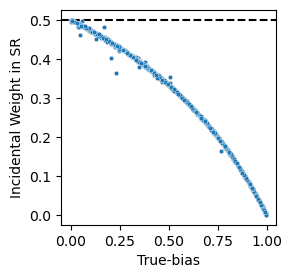

In [51]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.scatterplot(
    data = incidental_weights_df,
    x = 'segmentation',
    y = 'incidental_weight',
    s = 10
)
ax.set_xlabel('True-bias')
ax.set_ylabel('Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

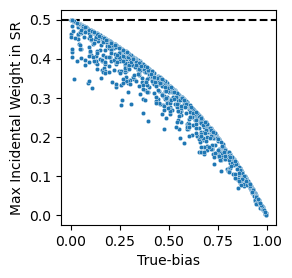

In [50]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.scatterplot(
    data = incidental_weights_df,
    x = 'segmentation',
    y = 'incidental_max_weight',
    s = 10
)
ax.set_xlabel('True-bias')
ax.set_ylabel('Max Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

# Training Analysis

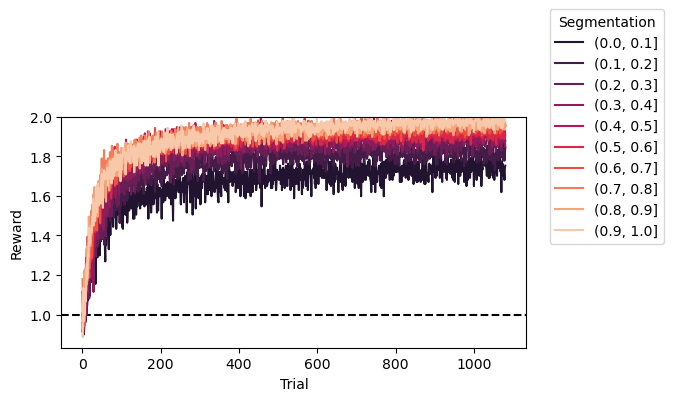

In [82]:
plot_training_curve(
    training_df,
    'reward',
    'segmentation_binned',
    legend_title = 'Segmentation',
    palette = sns.color_palette('rocket', 10)
)


In [10]:
training_df['target_freq_label'] = training_df['freq_target'].replace(
    {1: 'Frequent', 0: 'Infrequent'}
)
FREQUENCY_COLORS = {
    'Infrequent': '#4CC9F0',
    'Frequent': '#F72585'
}

In [11]:
for seg_label in seg_labels:
    idx = (
        (training_df['sdim'] == '2') &
        (training_df['bias'] == 'none') &
        (training_df['pairs'] == 'fact') &
        (training_df['depth'] == 1) &
        (training_df['segmentation_binned'] == seg_label)
    )
    plot_training_curve(
        training_df.loc[idx],
        'reward',
        'target_freq_label',
        palette = FREQUENCY_COLORS,
        hue_order = ['Infrequent', 'Frequent'],
        legend_title = 'Target Frequency',
        title = f'Segmentation = {seg_label}'
    )

NameError: name 'seg_labels' is not defined

In [33]:
# Label test targets/options as old (from training) or new
for model in MODELS:

    # Get targets and options seen during training
    idx = training_df['model_label'] == model
    training_targets = np.unique(training_df.loc[idx, 'target'])
    training_options = np.unique(training_df.loc[idx, 'options_comb'])

    # Label test targets and options as old or novel
    idx = test_df['model_label'] == model
    test_df.loc[idx, 'novel_target'] = np.isin(
        test_df.loc[idx, 'target'],
        training_targets,
        invert = True
    ).astype(int)
    test_df.loc[idx, 'novel_options'] = np.isin(
        test_df.loc[idx, 'options_comb'],
        training_options,
        invert = True
    ).astype(int)

# Get trials where options and target features match
test_df['options_target_comb_match'] = (
    test_df['options_comb'] == test_df['target_comb']
).astype(int)

# Label tesdt trials that would have been seen during training
test_df['old'] = (
    np.logical_not(test_df['novel_target']) &
    np.logical_not(test_df['novel_options']) &
    test_df['options_target_comb_match']
).astype(int)

# Get max points possible for each trial
target_combs = [convert_str_to_array(s) for s in test_df['target_comb']]
options_combs = [convert_str_to_array(s) for s in test_df['options_comb']]
target_combs = np.array(target_combs)
options_combs = np.array(options_combs)
test_df['max_reward'] = np.sum(
    (target_combs == options_combs) &
    (target_combs == 1),
    axis=1)

# Add training target information
test_df = pd.merge(
    test_df,
    training_df[[
        'id',
        'model_label',
        'target',
        'freq_target',
        'target_freq_label'
    ]],
)

test_df.head()

: 

In [20]:
test_summary_df = test_df[[
    'id',
    'target_freq_label',
    'old',
    'novel_target',
    'novel_options',
    'options_target_comb_match',
    'max_reward',
    'reward'
]].groupby(
    [
        'id',
        'target_freq_label',
        'old',
        'novel_target',
        'novel_options',
        'options_target_comb_match',
        'max_reward',
    ]
)
test_summary_df = test_summary_df.mean()
test_summary_df = test_summary_df.dropna()
test_summary_df = test_summary_df.reset_index()
test_summary_df = pd.merge(
    test_summary_df,
    subj_df,
    on = 'id'
)
test_summary_df

,id,target_freq_label,old,novel_target,novel_options,options_target_comb_match,max_reward,reward,model_label,sdim,depth,freq,pairs,bias,alpha,beta,gamma,segmentation,segmentation_binned
0,1,Frequent,0,0.0,0.0,0,0,0.0,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.568806,"(0.5, 0.6]"
1,1,Frequent,0,0.0,1.0,0,1,1.0,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.568806,"(0.5, 0.6]"
2,1,Frequent,1,0.0,0.0,1,2,2.0,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.568806,"(0.5, 0.6]"
3,1,Infrequent,0,0.0,0.0,0,0,0.0,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.568806,"(0.5, 0.6]"
4,1,Infrequent,0,0.0,1.0,0,1,1.0,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.568806,"(0.5, 0.6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1000,Frequent,0,0.0,1.0,0,1,1.0,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.137676,0.784628,1,0.807430,"(0.8, 0.9]"
5996,1000,Frequent,1,0.0,0.0,1,2,2.0,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.137676,0.784628,1,0.807430,"(0.8, 0.9]"
5997,1000,Infrequent,0,0.0,0.0,0,0,0.0,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.137676,0.784628,1,0.807430,"(0.8, 0.9]"
5998,1000,Infrequent,0,0.0,1.0,0,1,1.0,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,2,1,nonuniform,fact,none,0.137676,0.784628,1,0.807430,"(0.8, 0.9]"


/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_17496/2050468692.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


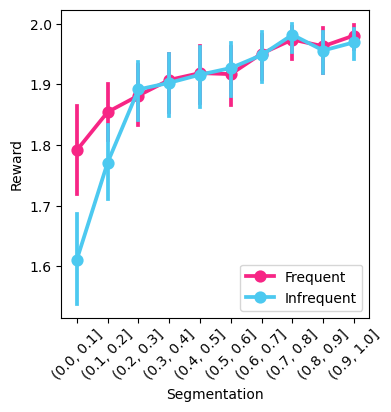

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))
idx = test_summary_df['old'] == 1
sns.pointplot(
    data = test_summary_df.loc[idx],
    x = 'segmentation_binned',
    y = 'reward',
    hue = 'target_freq_label',
    palette = FREQUENCY_COLORS,
    ax = ax
)
ax.set_xlabel('Segmentation')
ax.set_ylabel('Reward')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend()
set_axis_ratio(ax)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_17496/3958684593.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


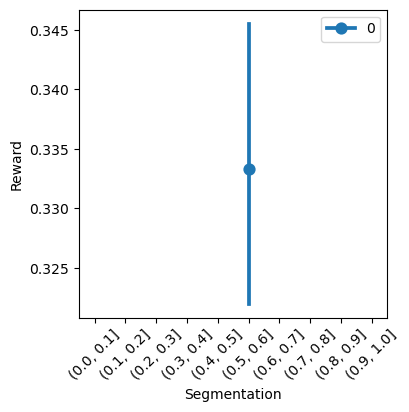

In [32]:
fig, ax = plt.subplots(figsize=(4, 4))
idx = test_summary_df['options_target_comb_match']
sns.pointplot(
    data = test_summary_df.loc[idx],
    x = 'segmentation_binned',
    y = 'reward',
    hue = 'old',
    ax = ax
)
ax.set_xlabel('Segmentation')
ax.set_ylabel('Reward')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend()
set_axis_ratio(ax)

<Axes: xlabel='old', ylabel='p'>

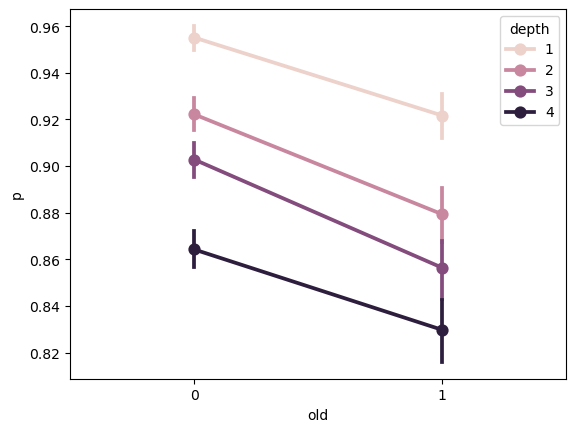

In [98]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform') &
    test_df['options_target_comb_match']
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'p',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='reward'>

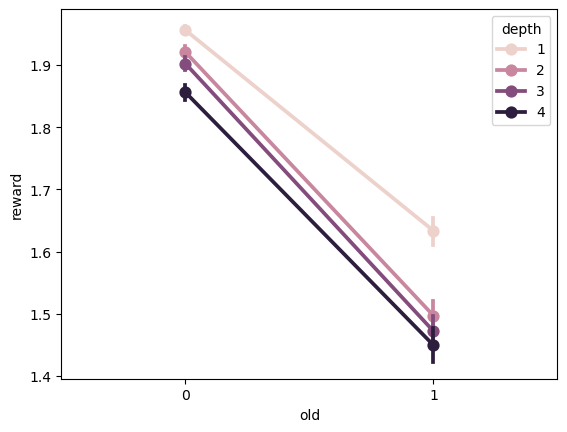

In [99]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform') &
    test_df['options_target_comb_match']
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='p'>

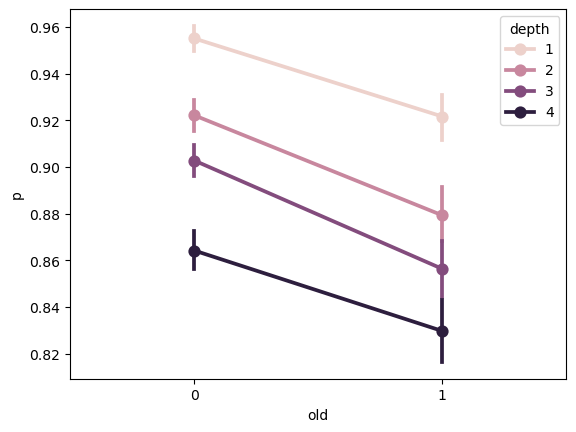

In [230]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform') &
    test_df['options_target_comb_match']
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'p',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='reward'>

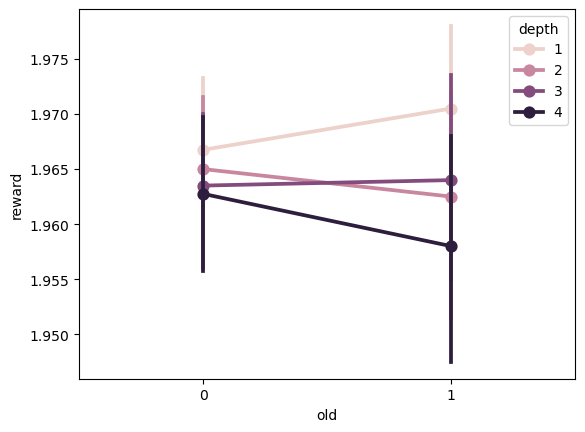

In [224]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'true') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform') &
    test_df['options_target_comb_match']
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

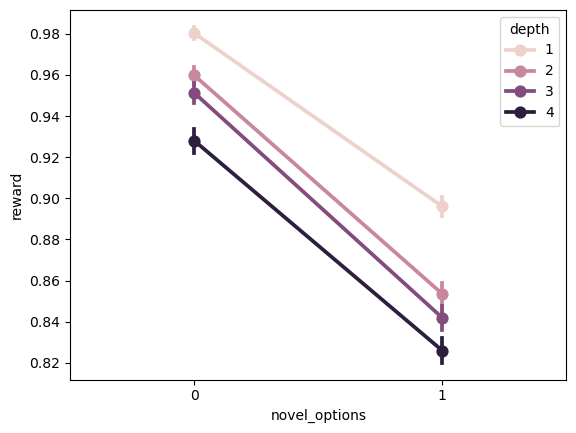

In [206]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform') &
    (test_df['max_reward'] == 1)
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='reward'>

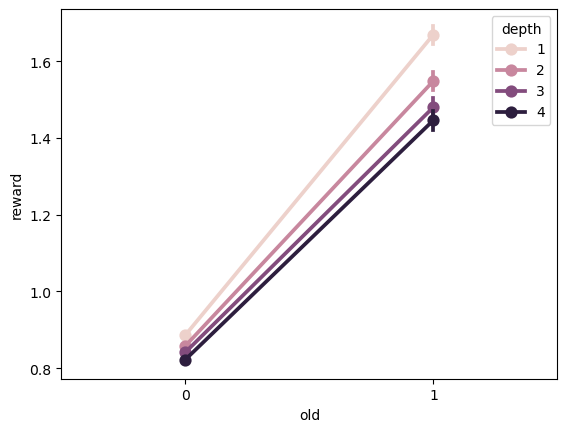

In [120]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='options_target_comb_match', ylabel='reward'>

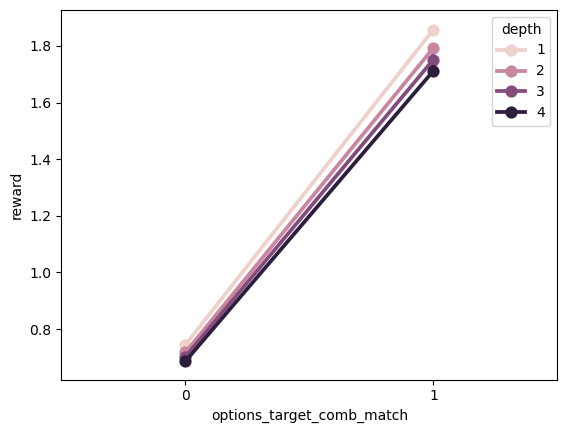

In [126]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'options_target_comb_match',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='reward'>

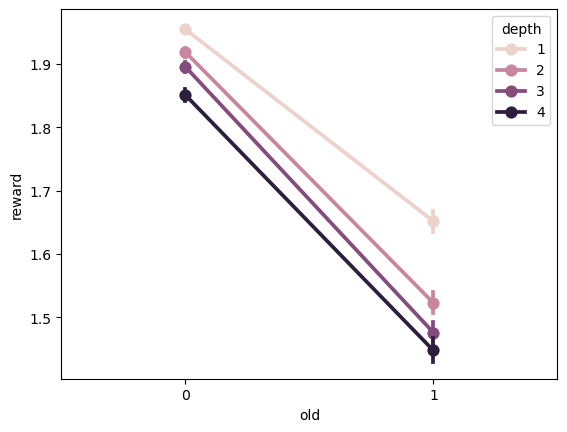

In [184]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    test_df['options_target_comb_match']
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

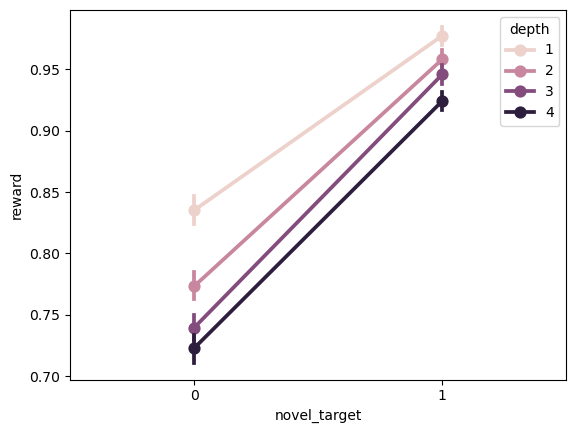

In [123]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform') 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

In [182]:
test_df.loc[idx, 'novel_target']

20         0
21         0
22         0
23         0
120        0
          ..
1463879    0
1463976    0
1463977    0
1463978    0
1463979    0
Name: novel_target, Length: 8000, dtype: object

<Axes: xlabel='novel_options', ylabel='reward'>

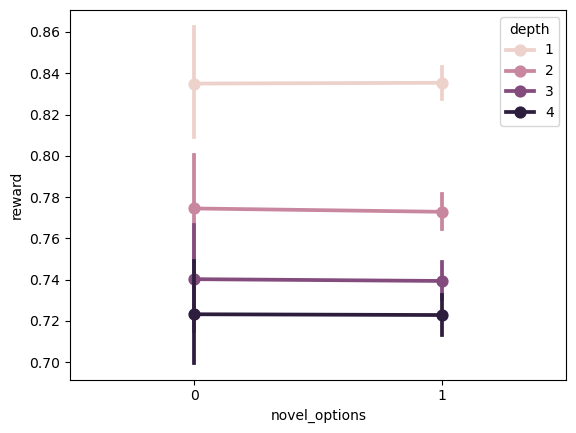

In [186]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform') &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

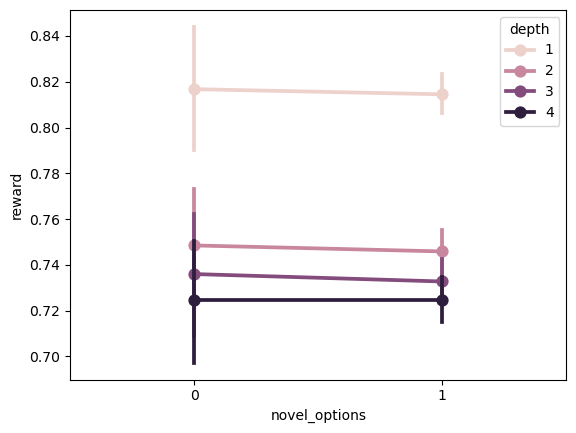

In [187]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform') &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

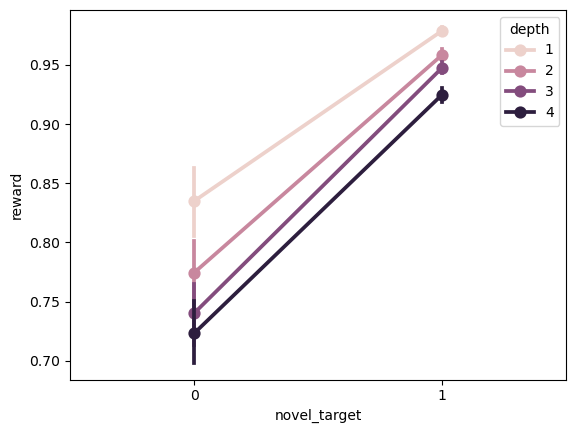

In [195]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform') &
    np.logical_not(test_df['novel_options']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

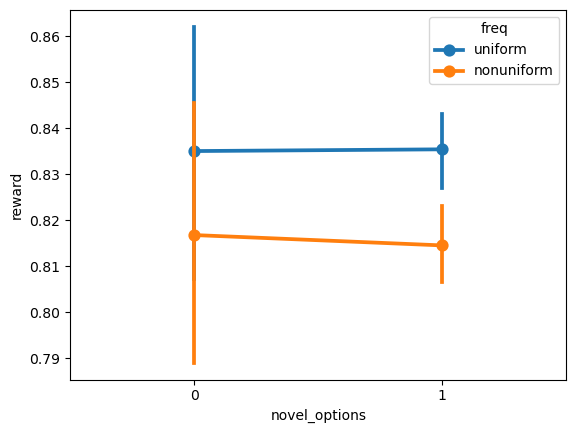

In [191]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 1) &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_options', ylabel='reward'>

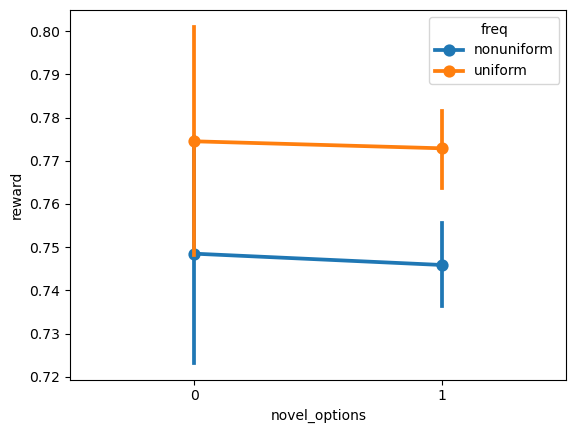

In [192]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 2) &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_options', ylabel='reward'>

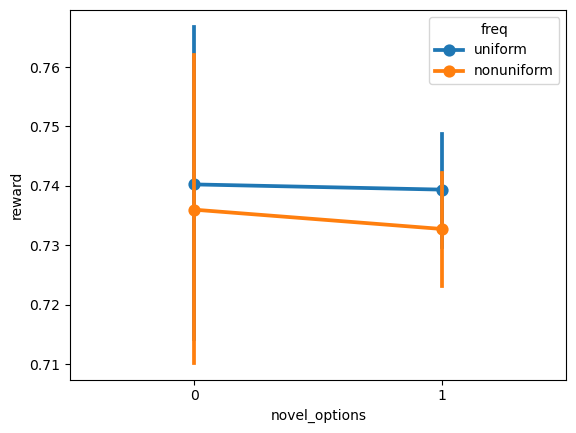

In [193]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 3) &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_options', ylabel='reward'>

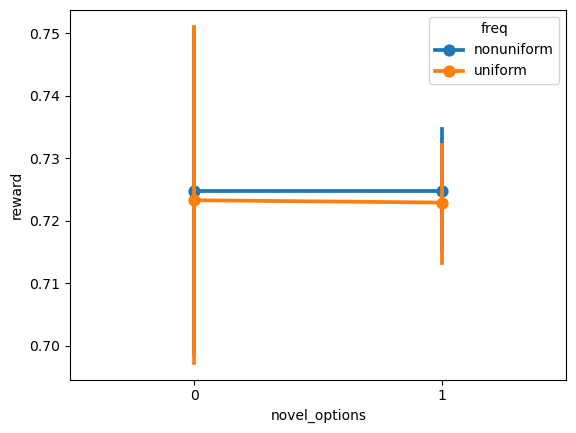

In [194]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 4) &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_options', ylabel='reward'>

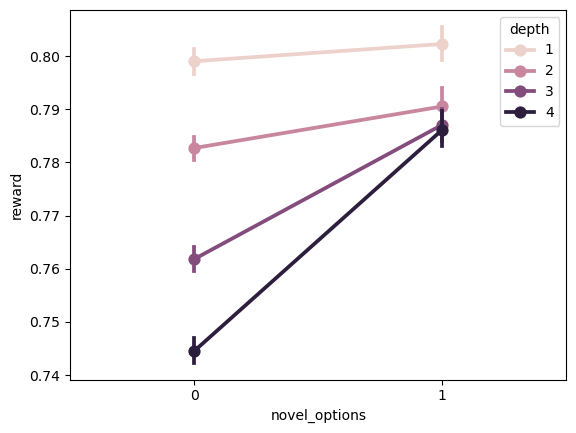

In [124]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform') 
)

sns.pointplot(
    data = test_df,
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

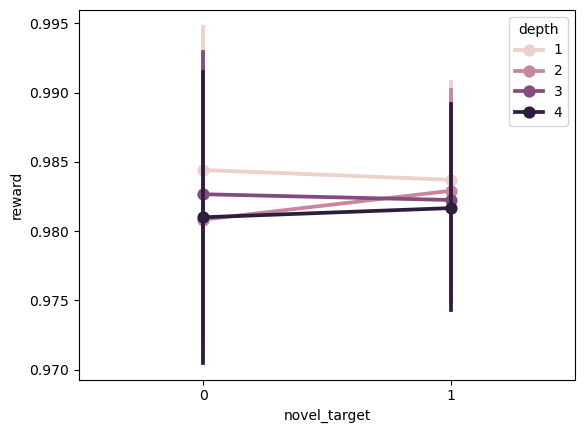

In [65]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'true') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

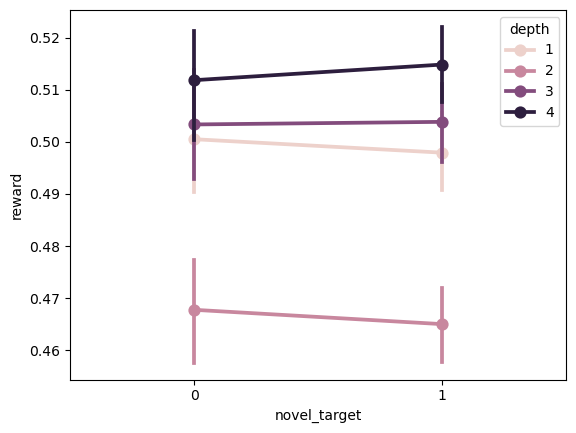

In [66]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'incidental') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

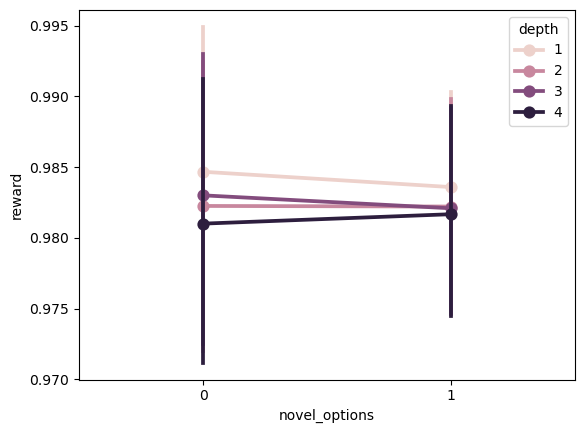

In [67]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'true') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

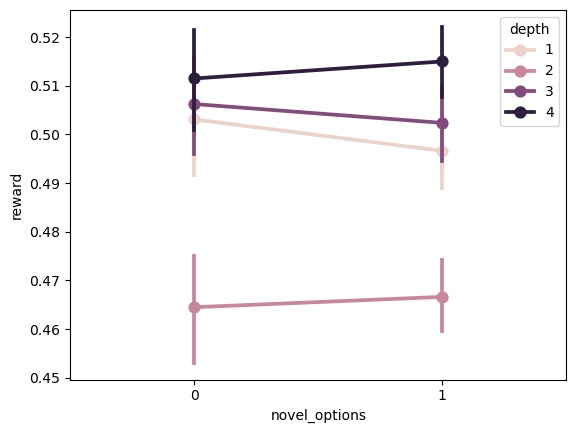

In [68]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'incidental') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='reward'>

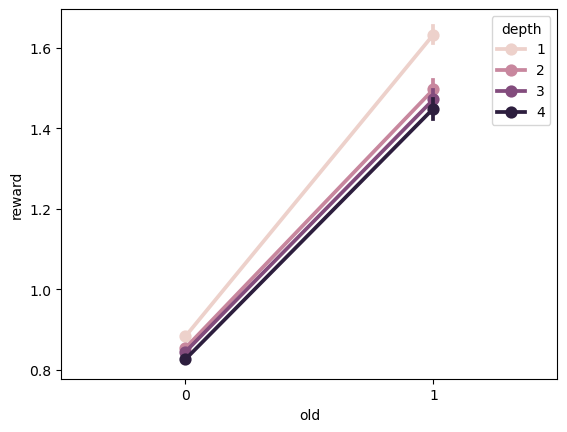

In [121]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

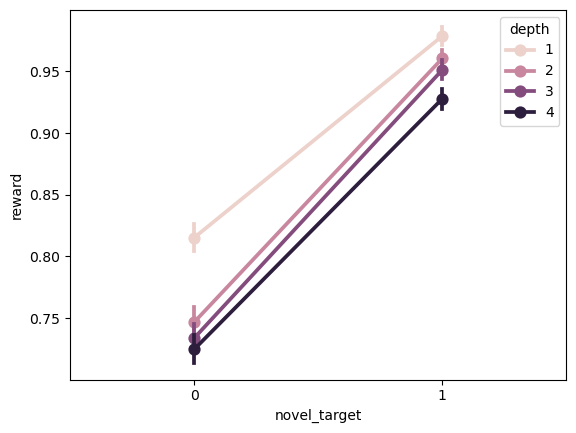

In [60]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

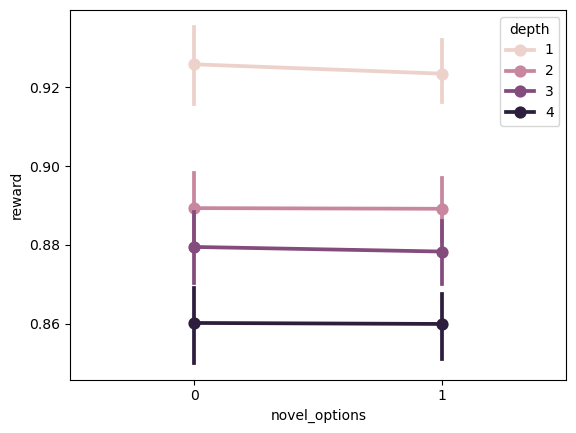

In [61]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

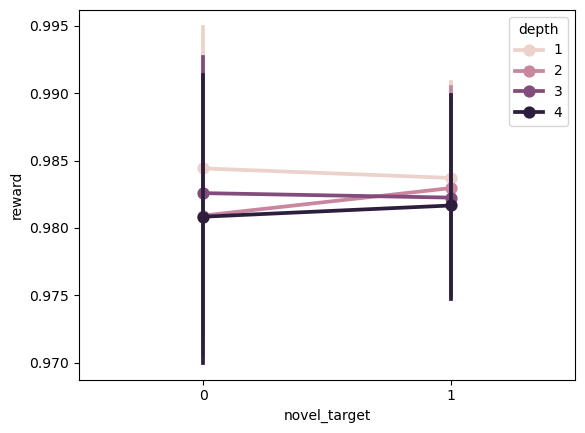

In [69]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'true') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

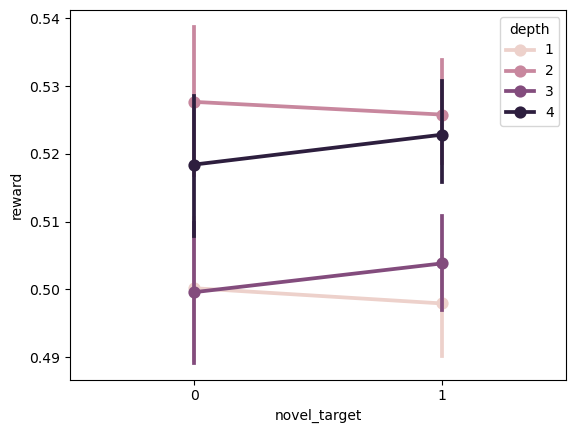

In [70]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'incidental') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

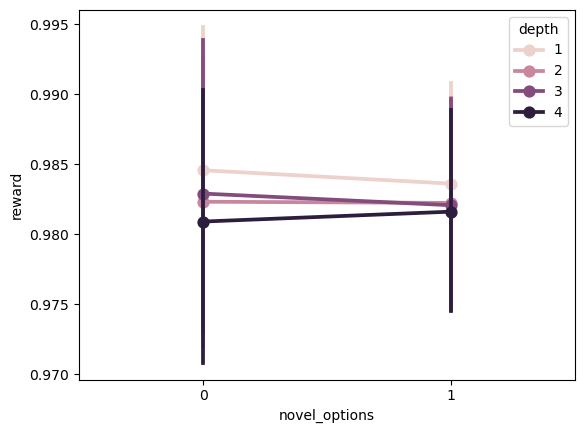

In [71]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'true') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

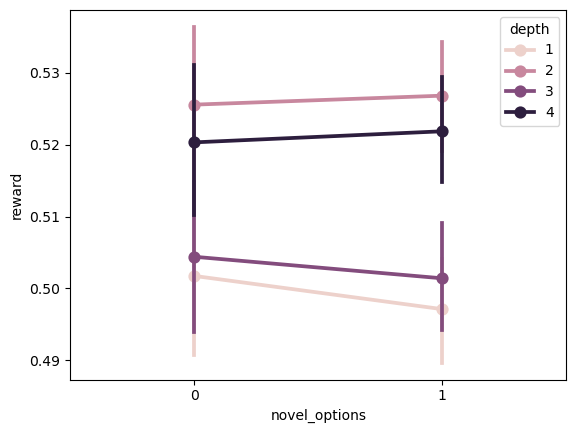

In [72]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'incidental') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

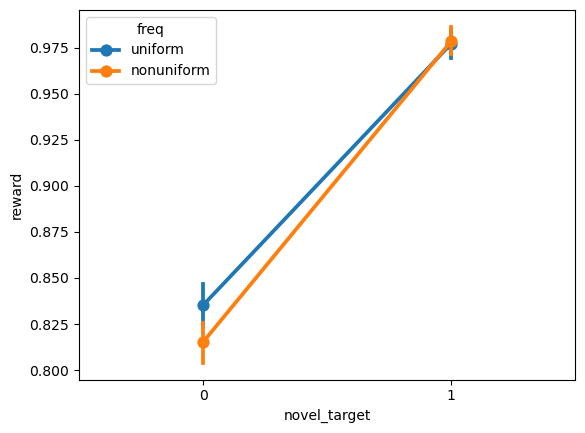

In [81]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 1)
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_target', ylabel='reward'>

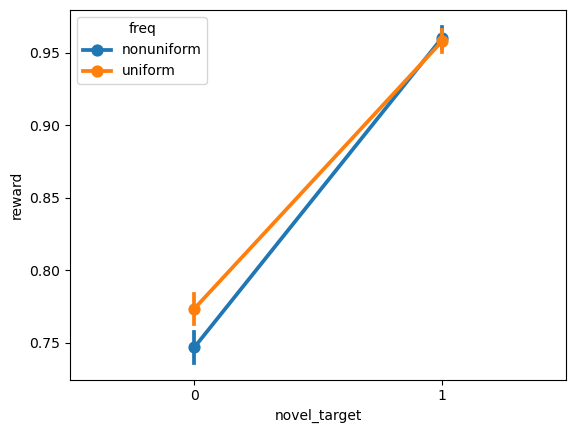

In [76]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 2)
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_target', ylabel='reward'>

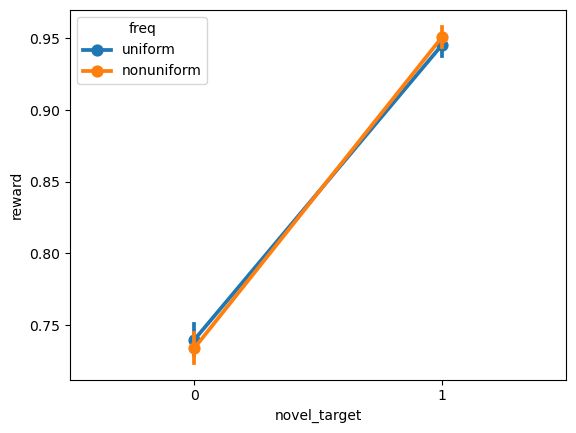

In [77]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 3)
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_target', ylabel='reward'>

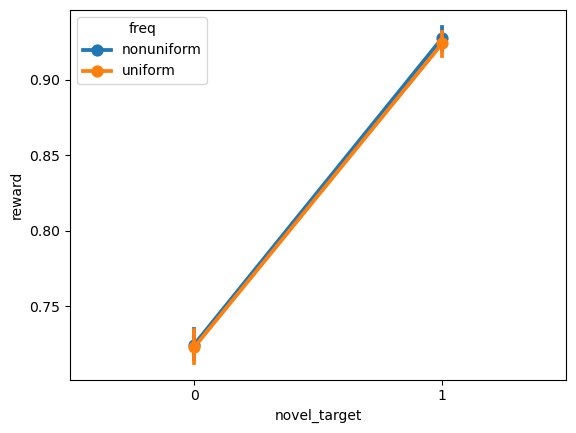

In [78]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 4)
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'freq'
)

### Transition Influence

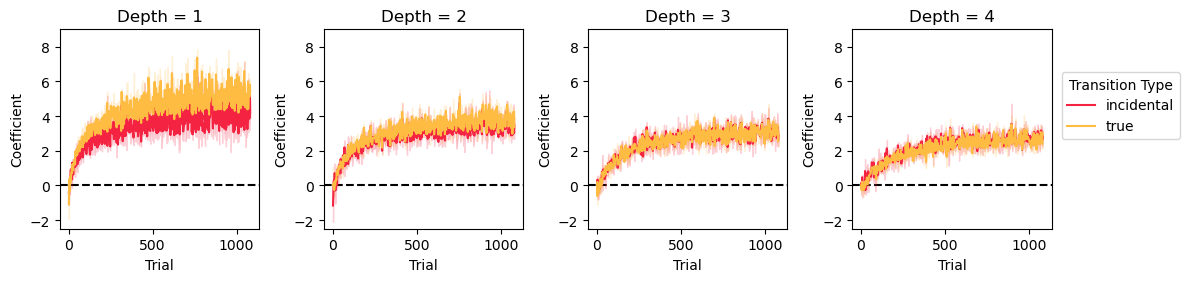

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['freq'] == 'uniform') &
        (trans_influence_trial_df['pairs'] == 'fact') 
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

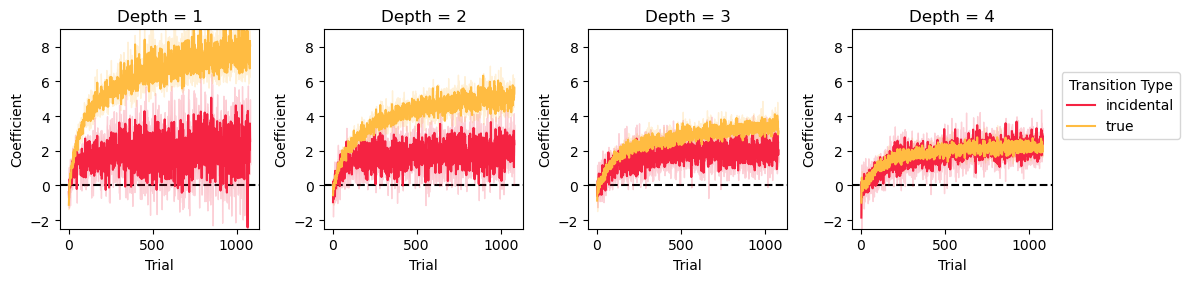

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['freq'] == 'uniform') &
        (trans_influence_trial_df['pairs'] == 'nonfact') 
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

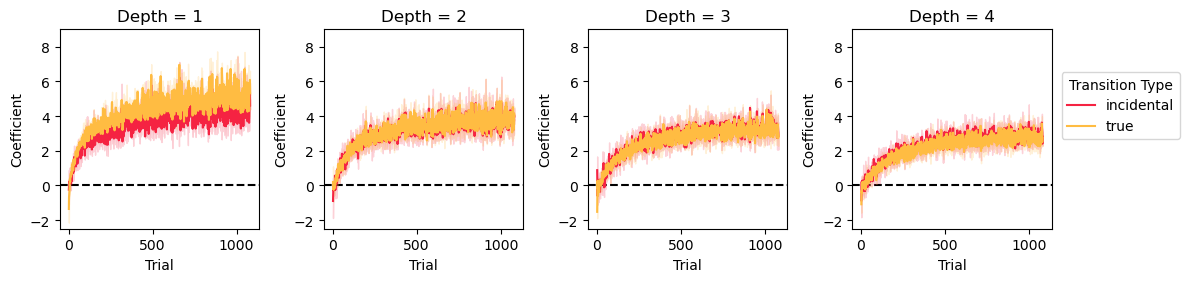

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['freq'] == 'nonuniform') &
        (trans_influence_trial_df['pairs'] == 'fact') 
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_57402/1305245321.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


AttributeError: 'NoneType' object has no attribute 'remove'

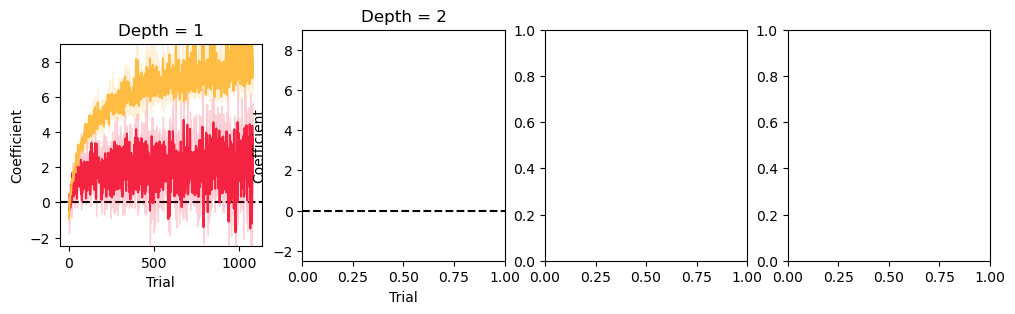

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['freq'] == 'nonuniform') &
        (trans_influence_trial_df['pairs'] == 'nonfact') 
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

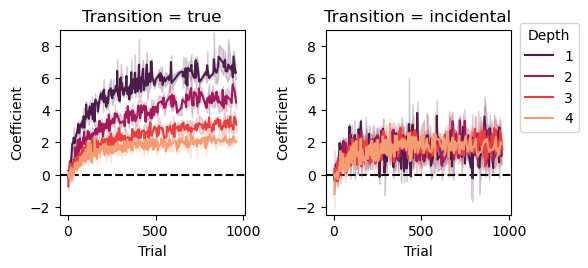

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
for i, transition in enumerate(['true', 'incidental']):
    ax = axs[i]
    idx = trans_influence_trial_df['transition'] == transition
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'depth',
        palette = 'rocket',
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Transition = {transition}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 1:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Depth', loc=(1.05, .45))
fig.tight_layout()

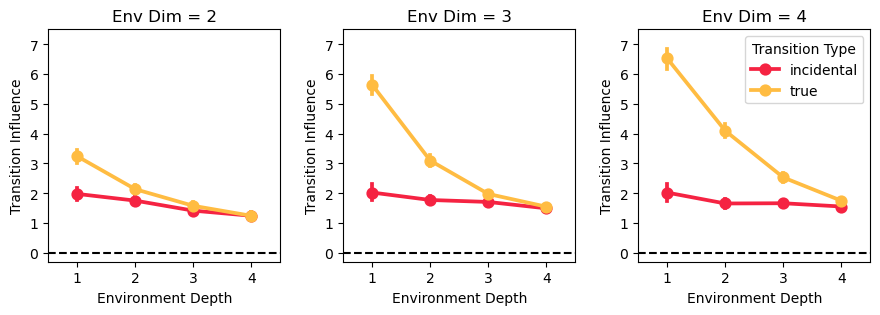

In [26]:
plot_df = trans_influence_df[['id', 'edim', 'depth', 'transition', 'coef']]
plot_df = plot_df.groupby(['id', 'edim', 'depth', 'transition'])
plot_df = plot_df.mean().reset_index()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, edim in enumerate(['2', '3', '4']):
    ax = axs[i]
    idx = plot_df['edim'] == edim
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.pointplot(
        data = plot_df.loc[idx],
        x = 'depth',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-.3, 7.5)
    ax.set_title(f'Env Dim = {edim}')
    ax.set_xlabel('Environment Depth')
    ax.set_ylabel('Transition Influence')
    if i < 2:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type')
fig.tight_layout()